# Import Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D, Input, Concatenate, GlobalMaxPooling2D
from keras.optimizers import Adam, schedules
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler
import keras_tuner as kt
from sklearn.model_selection import KFold
tf.random.set_seed(70)

# Some Functions

In [46]:
def plot_loss_acc(history):
    # plot the training and validation loss and accuracy
    # plot loss on train and validation
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss Of Model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # plot accuracy on train adn validation
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy Of Model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [47]:
# read the data as a dataframe
df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [48]:
# describe the data
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [49]:
# check if there are missing values
df.isnull().sum().sum()

0

- There is no any missing values

In [50]:
# check if there are duplicated values
df.duplicated().sum()

43

- There are some duplicated samples

In [51]:
# remove duplicated samples
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

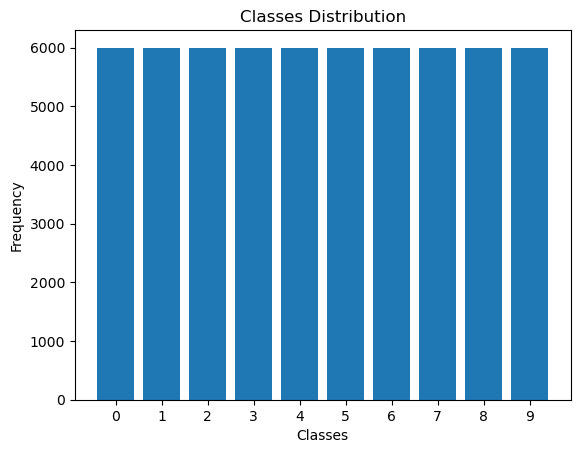

In [52]:
# visulize the data
plt.bar(df["label"].value_counts().index.values, df["label"].value_counts())
plt.xlabel("Classes")
plt.xticks(df["label"].value_counts().index.values)
plt.ylabel("Frequency")
plt.title("Classes Distribution")
plt.show();

- As we can see the data is very balanced(each class has the same number of samples.
- The label column is already encoded (ordinal encoding).

# Split the data into Features and Labels

In [53]:
X = df.drop("label", axis=1)
y = df["label"]

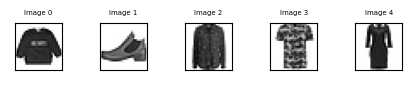

In [54]:
# create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(5, 5))

# plot the images on the subplots
for i in range(5):
  axs[i].imshow(X.iloc[i].values.reshape(28, 28), cmap="binary")
  axs[i].set_title(f'Image {i}',fontdict={"fontsize":5})


# hide the axis ticks and labels
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# show the figure
plt.subplots_adjust(hspace=0.7, wspace=0.8)
plt.show()

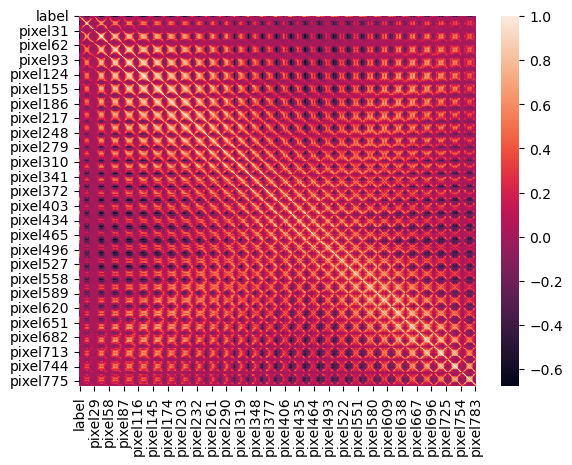

In [55]:
# correlation analysis
corr = df.corr()
sns.heatmap(corr);

In [56]:
# reshape samples into matrix 28x28 and add padding to become 32x32
X = X.values.reshape(-1, 28, 28)
X = tf.pad(X, [[0, 0], [2, 2], [2, 2]]) # padding
X = tf.expand_dims(X, axis=3, name=None).numpy()

In [57]:
X.shape

(59957, 32, 32, 1)

In [58]:
# normalizing the images pixels
X = X / 255

# Split the data

In [59]:
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values, test_size=0.1, random_state=42)

# split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

# Models

## LeNet 5

In [43]:
# this function to schedule the learning rate
def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * 0.1

# this function to build the model (LeNet 5 Structure)
def build_model(hyper):
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)))
    model.add(MaxPool2D(strides=2))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPool2D(strides=2))
    model.add(Flatten())

    # values to tune the two hidden layers nodes
    units_1 = hyper.Choice('units_1', values=[128, 256])
    units_2 = hyper.Choice('units_2', values=[32, 64, 128, ])
    model.add(Dense(units=units_1, activation='relu'))
    model.add(Dense(units=units_2, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # values to tune learning rate
    learning_rate = hyper.Choice('learning_rate',
                                 values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# this function is used to tune hyperparameters and find best ones
def find_best(model, X_train, y_train, X_val, y_val):
  # callbacks parameters
  lr_scheduler = LearningRateScheduler(scheduler)
  early_stop = EarlyStopping(monitor='val_loss', patience=4)

  # search for the best
  model = kt.Hyperband(model, objective='val_accuracy', seed=70, overwrite=True)
  model.search(X_train, y_train, validation_data=(X_val, y_val), batch_size=50, callbacks=[early_stop, lr_scheduler])
  return model

In [44]:
model_tuner = find_best(build_model, X_train, y_train, X_val, y_val)

Trial 16 Complete [00h 00m 09s]
val_accuracy: 0.8430609703063965

Best val_accuracy So Far: 0.883824348449707
Total elapsed time: 00h 02m 48s


In [46]:
best_hypers = model_tuner.get_best_hyperparameters()[0]
# print the best hyperparameters
print(f"Best hyperparameters: {best_hypers.values}")

Best hyperparameters: {'units_1': 256, 'units_2': 32, 'learning_rate': 0.001, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


- As we can see the best hyperparameters are:
    - No. units of first hidden layer: 256
    - No. units of second hidden layer: 32
    - learning_rate: 0.001

- We will build the best model with the previous missioned best hyperparameters

In [47]:
# build and train the model with best hyperparameters
early_stop = EarlyStopping(monitor='val_loss', patience=4)
model = model_tuner.hypermodel.build(best_hypers)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
          epochs=30, batch_size=50, callbacks=[early_stop])

Epoch 1/30
972/972 [==============================] - 4s 4ms/step - loss: 0.5632 - accuracy: 0.7964 - val_loss: 0.3981 - val_accuracy: 0.8577
Epoch 2/30
972/972 [==============================] - 3s 3ms/step - loss: 0.3670 - accuracy: 0.8689 - val_loss: 0.3368 - val_accuracy: 0.8810
Epoch 3/30
972/972 [==============================] - 3s 3ms/step - loss: 0.3207 - accuracy: 0.8822 - val_loss: 0.3266 - val_accuracy: 0.8825
Epoch 4/30
972/972 [==============================] - 3s 4ms/step - loss: 0.2916 - accuracy: 0.8921 - val_loss: 0.3122 - val_accuracy: 0.8911
Epoch 5/30
972/972 [==============================] - 3s 3ms/step - loss: 0.2699 - accuracy: 0.9005 - val_loss: 0.2937 - val_accuracy: 0.8944
Epoch 6/30
972/972 [==============================] - 4s 4ms/step - loss: 0.2497 - accuracy: 0.9073 - val_loss: 0.2895 - val_accuracy: 0.8964
Epoch 7/30
972/972 [==============================] - 4s 4ms/step - loss: 0.2336 - accuracy: 0.9139 - val_loss: 0.2790 - val_accuracy: 0.8999
Epoch 

- plot loss and accuracy on train and validation

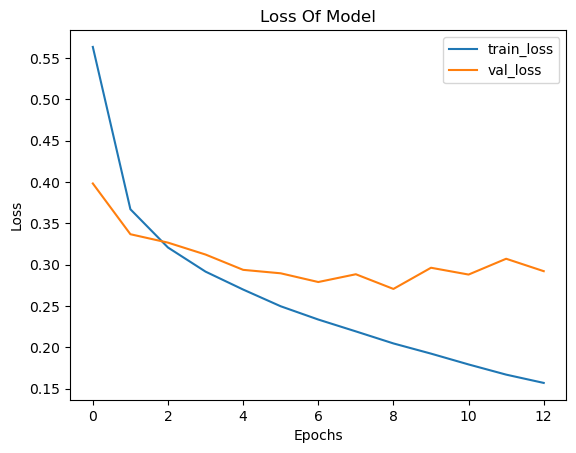

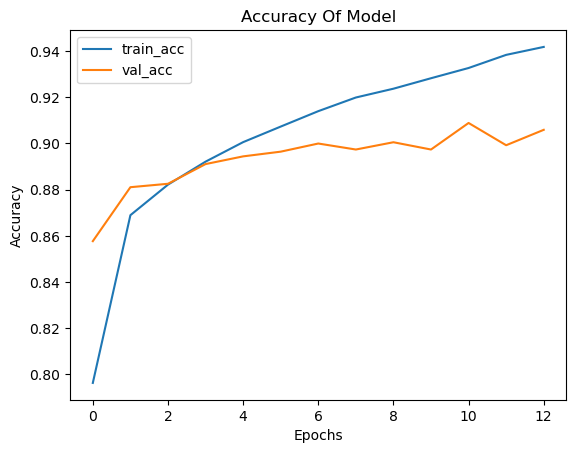

In [53]:
# plot loss and accuracy on train and test
plot_loss_acc(history)

- Check the model performace in general(Generalization of model)

In [54]:
# evaluate the model on test data
model.evaluate(X_test, y_test)

188/188 [==============================] - 1s 3ms/step - loss: 0.3125 - accuracy: 0.8983


[0.31249210238456726, 0.8982654809951782]

- As we can see the model generalizes well on test data:
       - loss: 0.31
       - accuracy: 0.898

- Evaluate the model with Cross-Validation

In [112]:
kfold = KFold(n_splits=5, random_state=70, shuffle=True)
histories, losses, accs = [], [], []
train_val_folds = kfold.split(X_train)
model = model_tuner.hypermodel.build(best_hypers)
i = 1
for train, val in train_val_folds:
    print("###############################################################################################")
    print(f"{i} fold:\n")
    
    # train the model on training folds and validation folds
    history = model.fit(X_train[train], y_train[train], validation_data=(X_train[val], y_train[val]), 
          epochs=10, batch_size=50)
    
    # evaluate the model on validation fold and store it
    loss, acc = model.evaluate(X_train[val], y_train[val])
    losses.append(loss)
    accs.append(acc)
    
    # store the histories of loss and accuracy for each kfold
    histories.append(history.history)
    i += 1

###############################################################################################
1 fold:

Epoch 1/10
778/778 [==============================] - 4s 4ms/step - loss: 0.6114 - accuracy: 0.7787 - val_loss: 0.4611 - val_accuracy: 0.8328
Epoch 2/10
778/778 [==============================] - 3s 4ms/step - loss: 0.3971 - accuracy: 0.8572 - val_loss: 0.3787 - val_accuracy: 0.8649
Epoch 3/10
778/778 [==============================] - 3s 4ms/step - loss: 0.3417 - accuracy: 0.8756 - val_loss: 0.3455 - val_accuracy: 0.8796
Epoch 4/10
778/778 [==============================] - 3s 4ms/step - loss: 0.3152 - accuracy: 0.8850 - val_loss: 0.3306 - val_accuracy: 0.8820
Epoch 5/10
778/778 [==============================] - 3s 4ms/step - loss: 0.2873 - accuracy: 0.8948 - val_loss: 0.3369 - val_accuracy: 0.8773
Epoch 6/10
778/778 [==============================] - 3s 4ms/step - loss: 0.2665 - accuracy: 0.9026 - val_loss: 0.3114 - val_accuracy: 0.8935
Epoch 7/10
778/778 [=======================

In [113]:
# concatenate the training history of each fold into a single history object
history = {}
for key in histories[0].keys():
    history[key] = np.concatenate([fold_history[key] for fold_history in histories])

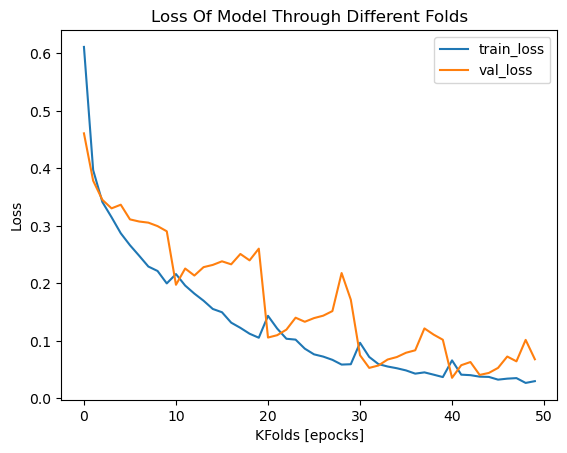

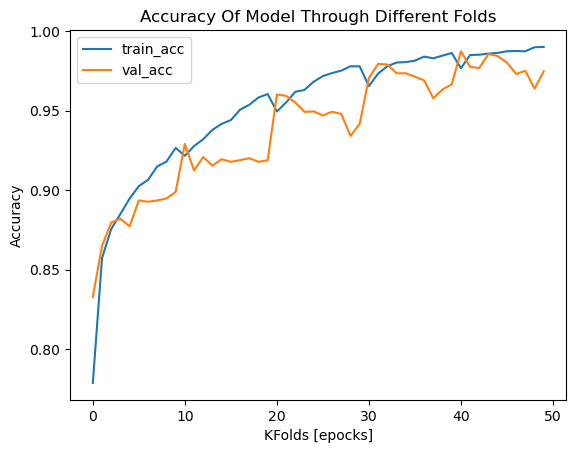

In [114]:
    # plot the training and validation loss and accuracy of Cross-Validation
    # plot loss on train and validation
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title("Loss Of Model Through Different Folds")
    plt.xlabel("KFolds [epocks]")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # plot accuracy on train adn validation
    plt.plot(history['accuracy'], label='train_acc')
    plt.plot(history['val_accuracy'], label='val_acc')
    plt.title("Accuracy Of Model Through Different Folds")
    plt.xlabel("KFolds [epocks]")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [118]:
print(f"the average losses through validation folds: {round(np.mean(losses), 2)}\n")
print(f"the average accuracies through validation folds: {round(np.mean(accs), 2)}\n")

the average losses through validation folds: 0.18

the average accuracies through validation folds: 0.94



- As we can see the model generalizes well on Cross-Validation Folds too.

- ### Comment on why you think LeNet-5 further improves the accuracy if any at all. And if it doesn't, why not?

- I think LeNet-5 improves the accuracy.
- explanation:
    - A hand-built model(LeNet-5 in our case) involves designing and training a neural network from scratch, where the architecture, hyperparameters, and weights are all learned on the specific task and dataset at hand. This approach can be effective when the dataset is large and diverse, and when the task at hand is well-defined and specific. Hand-built models also offer greater flexibility and control over the network architecture and training process, which can be useful for specialized applications.

## ResNet

- We will use RESNet152V2 as a transfer learing agorithm, we will fix the convolution layers and modify FNN layers.

In [37]:
from keras.applications import ResNet152V2


# duplicate the shape of input into 3 channels
channels = 3
input_reshape = Concatenate()([Input(shape=(32, 32, 1))]* channels) 

# create a ResNet152V2 model with the modified input shape
resnet_model = ResNet152V2(weights='imagenet', include_top=False, 
                        input_tensor=input_reshape)

# add classification layers on top of the ResNet152V2 base model
x = resnet_model.output
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=resnet_model.input, outputs=predictions)

# freeze all convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False
    
# compile the model with an appropriate loss function and optimizer
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam',
              metrics=['accuracy'])



In [38]:
# train the model
early_stop = EarlyStopping(patience=4)
lr_scheduler = LearningRateScheduler(scheduler)
resNet_history = model.fit(X_train, y_train, epochs=50, batch_size=50, 
                           validation_data=(X_val, y_val), 
                           callbacks=[early_stop, lr_scheduler])

Epoch 1/50
972/972 [==============================] - 125s 47ms/step - loss: 0.8060 - accuracy: 0.7094 - val_loss: 0.6171 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 2/50
972/972 [==============================] - 44s 45ms/step - loss: 0.6373 - accuracy: 0.7646 - val_loss: 0.6089 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 3/50
972/972 [==============================] - 42s 44ms/step - loss: 0.5910 - accuracy: 0.7807 - val_loss: 0.5771 - val_accuracy: 0.7951 - lr: 0.0010
Epoch 4/50
972/972 [==============================] - 44s 45ms/step - loss: 0.5596 - accuracy: 0.7914 - val_loss: 0.5514 - val_accuracy: 0.7993 - lr: 0.0010
Epoch 5/50
972/972 [==============================] - 43s 45ms/step - loss: 0.5340 - accuracy: 0.8028 - val_loss: 0.5431 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 6/50
972/972 [==============================] - 42s 43ms/step - loss: 0.5143 - accuracy: 0.8098 - val_loss: 0.5471 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 7/50
972/972 [==============================] - 44s

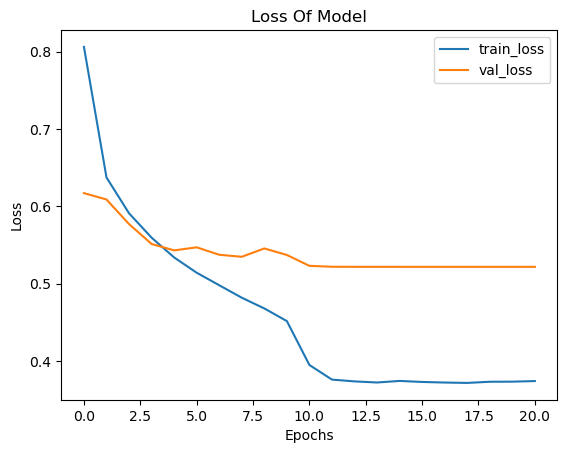

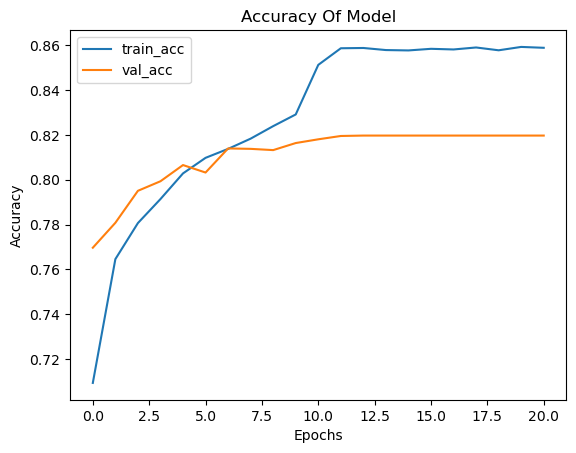

In [40]:
# plot the loss and accuracy on training and validation
plot_loss_acc(resNet_history)

- evalute the model to check its generalization

In [39]:
# evalute the model on test data
model.evaluate(X_test, y_test)

188/188 [==============================] - 7s 36ms/step - loss: 0.5628 - accuracy: 0.8074


[0.5627942085266113, 0.8073715567588806]

- As we can see the model achieved good accuracy and loss(it generalizes well):
    - loss: 0.5628
    - accuracy: 0.8074
- But the "LeNet 5" was better than this model.

## Xception

- We will use Xception as a transfer learing agorithm, we will fix the convolution layers and modify FNN layers.

In [41]:
from keras.applications import Xception


# duplicate the shape of input into 3 channels
channels = 3
input_reshape = Concatenate()([Input(shape=(32, 32, 1))]* channels) 

# create an Xception model with the modified input shape
Xception_model = Xception(weights='imagenet', include_top=False, 
                        input_tensor=input_reshape)

# add classification layers on top of the Xception base model
x = Xception_model.output
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=Xception_model.input, outputs=predictions)

# freeze all convolutional layers
for layer in Xception_model.layers:
    layer.trainable = False
    
# compile the model with an appropriate loss function and optimizer
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam',
              metrics=['accuracy'])

83683744/83683744 [==============================] - 0s 0us/step


In [42]:
# train the model
early_stop = EarlyStopping(patience=4)
lr_scheduler = LearningRateScheduler(scheduler)
Xception_history = model.fit(X_train, y_train, epochs=50, batch_size=50, 
                           validation_data=(X_val, y_val), 
                           callbacks=[early_stop, lr_scheduler])

Epoch 1/50
972/972 [==============================] - 20s 17ms/step - loss: 0.9992 - accuracy: 0.6323 - val_loss: 0.7853 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 2/50
972/972 [==============================] - 14s 14ms/step - loss: 0.7882 - accuracy: 0.7091 - val_loss: 0.8135 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 3/50
972/972 [==============================] - 13s 14ms/step - loss: 0.7327 - accuracy: 0.7274 - val_loss: 0.7787 - val_accuracy: 0.7187 - lr: 0.0010
Epoch 4/50
972/972 [==============================] - 13s 14ms/step - loss: 0.6916 - accuracy: 0.7446 - val_loss: 0.7373 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 5/50
972/972 [==============================] - 14s 14ms/step - loss: 0.6599 - accuracy: 0.7537 - val_loss: 0.7292 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 6/50
972/972 [==============================] - 14s 14ms/step - loss: 0.6334 - accuracy: 0.7638 - val_loss: 0.7245 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 7/50
972/972 [==============================] - 13s 

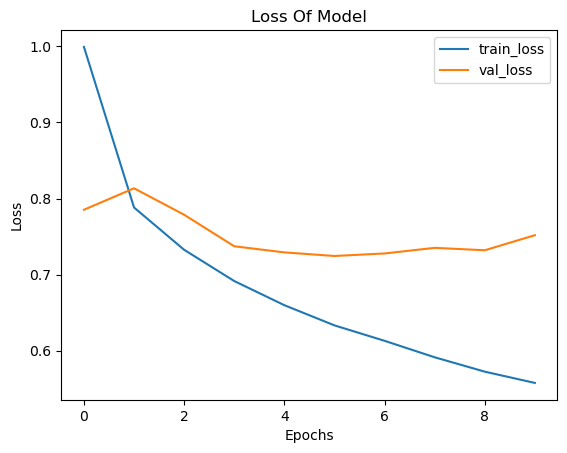

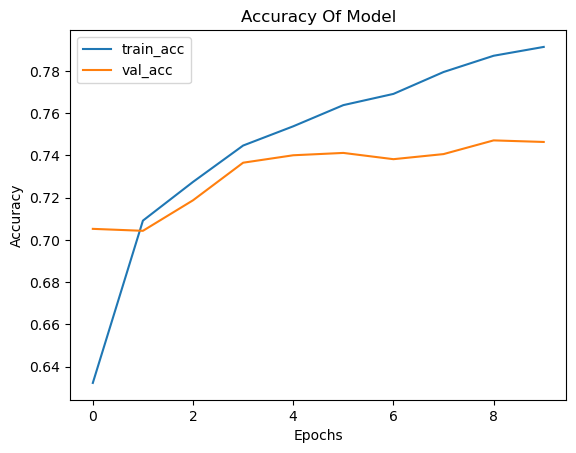

In [43]:
# plot the loss and accuracy on training and validation
plot_loss_acc(Xception_history)

- evalute the model to check its generalization

In [44]:
# evalute the model on test data
model.evaluate(X_test, y_test)

188/188 [==============================] - 3s 14ms/step - loss: 0.7386 - accuracy: 0.7470


[0.7386459112167358, 0.7469980120658875]

- Unfortunaitely the model performace is very bad, where the accuracy and loss:
    - loss: 0.7386
    - accuracy: 0.7470
- The "LeNet 5" and "RESNet152V2" are better than this model.

## VGG16

- We will use VGG16 as a transfer learing agorithm, we will fix the convolution layers and modify FNN layers.

In [60]:
from keras.applications import VGG16


# duplicate the shape of input into 3 channels
channels = 3
input_reshape = Concatenate()([Input(shape=(32, 32, 1))]* channels) 

# create a VGG16 model with the modified input shape
VGG16_model = VGG16(weights='imagenet', include_top=False, 
                        input_tensor=input_reshape)

# add classification layers on top of the VGG16 base model
x = VGG16_model.output
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=VGG16_model.input, outputs=predictions)

# freeze all convolutional layers
for layer in VGG16_model.layers:
    layer.trainable = False
    
# compile the model with an appropriate loss function and optimizer
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [61]:
# train the model
early_stop = EarlyStopping(patience=4)
lr_scheduler = LearningRateScheduler(scheduler)
VGG16_history = model.fit(X_train, y_train, epochs=50, batch_size=50, 
                           validation_data=(X_val, y_val), 
                           callbacks=[early_stop, lr_scheduler])

Epoch 1/50
972/972 [==============================] - 13s 11ms/step - loss: 0.6473 - accuracy: 0.7629 - val_loss: 0.4602 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 2/50
972/972 [==============================] - 11s 11ms/step - loss: 0.4866 - accuracy: 0.8226 - val_loss: 0.4172 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 3/50
972/972 [==============================] - 10s 10ms/step - loss: 0.4544 - accuracy: 0.8351 - val_loss: 0.4373 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 4/50
972/972 [==============================] - 11s 11ms/step - loss: 0.4288 - accuracy: 0.8448 - val_loss: 0.3974 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 5/50
972/972 [==============================] - 11s 11ms/step - loss: 0.4129 - accuracy: 0.8486 - val_loss: 0.3782 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 6/50
972/972 [==============================] - 10s 10ms/step - loss: 0.3999 - accuracy: 0.8551 - val_loss: 0.3829 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 7/50
972/972 [==============================] - 10s 

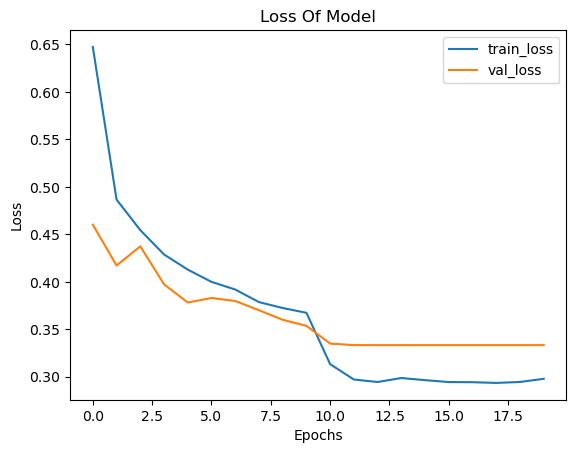

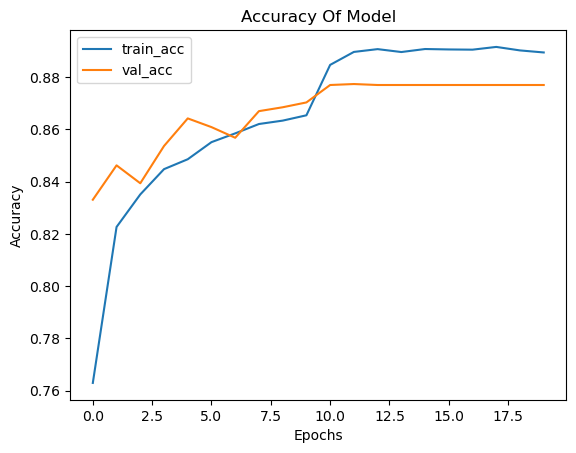

In [62]:
# plot the loss and accuracy on training and validation
plot_loss_acc(VGG16_history)

- evalute the model to check its generalization

In [63]:
# evalute the model on test data
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 8ms/step - loss: 0.3254 - accuracy: 0.8839


[0.32541623711586, 0.8839226365089417]

- The model performace is very good, where the accuracy and loss:
    - loss: 0.3254
    - accuracy: 0.8839
- It's better than "RESNet152V2", and "Xception" for our data.